### Imports

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from DQNutils.MemoryBuffer import ReplayMemory, Transition
from DQNutils.Q_network import DQN
from DQNutils.DQN_params import *
from DQNutils.DQN_train import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create Environment, Memory Buffer, policy and target networks, optimizers

In [2]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0
num_episodes = 1000
episode_durations = []

### Main Loop

100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]


Complete


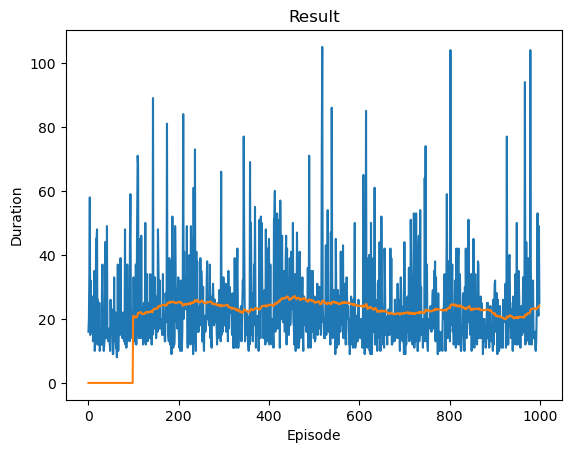

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state, policy_net, env, steps_done, device)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(memory, policy_net, target_net, optimizer, device)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations(episode_durations)
            break

print('Complete')
plot_durations(episode_durations, show_result=True)
# plt.ioff()
plt.show()

### Record Video

In [4]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

num_eval_episodes = 4

env = gym.make("CartPole-v1", render_mode="rgb_array")  
env = RecordVideo(env, video_folder="./videos", name_prefix="DQN-cart-pole", episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

    episode_over = False
    while not episode_over:
        action = select_action(obs, policy_net, env, steps_done, device)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action.item())

        episode_over = terminated or truncated
        if not episode_over:
            obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

/home/airl-gpu5-mini/anaconda3/envs/PhysicsModels/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/airl-gpu5-mini/sourav/sourav/RL algorithms/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode time taken: deque([0.02654, 0.056881, 0.044002, 0.05015], maxlen=4)
Episode total rewards: deque([11.0, 19.0, 12.0, 16.0], maxlen=4)
Episode lengths: deque([11, 19, 12, 16], maxlen=4)


### Python script call 
!python3 DQN_catrpole.py